**Table of contents**<a id='toc0_'></a>    
- 1. [Load model through mlflow pyfunc when the model is in the model registry](#toc1_)    
- 2. [Find the model best threshold in MLflow tracking info](#toc2_)    
- 3. [Check prediction function](#toc3_)    
- 4. [ Understand SHAP values for lightGBM and feature importance](#toc4_)    
  - 4.1. [Local interpretability](#toc4_1_)    
  - 4.2. [Global interpretability](#toc4_2_)    
  - 4.3. [How to automate the extraction of the feature importance rank.](#toc4_3_)    
  - 4.4. [Save shap plots](#toc4_4_)    
    - 4.4.1. [Summary_plot](#toc4_4_1_)    
    - 4.4.2. [waterfall plot](#toc4_4_2_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1.  [&#9650;](#toc0_) <a id='toc1_'></a>Load model through mlflow pyfunc when the model is in the model registry

In [1]:
import mlflow.pyfunc
import mlflow
import pandas as pd
import api_utils
from flask import Flask, jsonify
import shap
import matplotlib.pyplot as plt

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
mlflow.set_tracking_uri("file:///home/louberehc/OCR/projets/7_scoring_model/mlruns")
tracking_uri = mlflow.get_tracking_uri()
tracking_uri

'file:///home/louberehc/OCR/projets/7_scoring_model/mlruns'

In [3]:
def make_model_uri(model_name: str, stage: str):
    return f"models:/{model_name}/{stage}"


def load_model(model_uri):
    """ Load the model from the artifacts in the MLflow model registry """
    return mlflow.pyfunc.load_model(model_uri=model_uri)


def load_data(DATA_PATH):
    """ Load both the features and the target associated to customers """
    df = pd.read_pickle(DATA_PATH)
    target = df.pop('TARGET')
    return df, target

# Load model and data
model_name = "lgbm_test"
stage = "Staging"
APP_DATA_PATH = "/home/louberehc/OCR/projets/7_scoring_model/pickle_files/reduced_data.pkl"

model_uri = make_model_uri(model_name, stage)
requirements = mlflow.pyfunc.get_model_dependencies(model_uri)


2023/09/13 17:00:22 INFO mlflow.pyfunc: To install the dependencies that were used to train the model, run the following command: '%pip install -r /home/louberehc/OCR/projets/7_scoring_model/mlruns/122196375156606001/de0e63da02a1439c8aae7fb7074e33a6/artifacts/lgbm_model/requirements.txt'.


In [4]:
requirements

'/home/louberehc/OCR/projets/7_scoring_model/mlruns/122196375156606001/de0e63da02a1439c8aae7fb7074e33a6/artifacts/lgbm_model/requirements.txt'

In [5]:
!cat '/home/louberehc/OCR/projets/7_scoring_model/mlruns/122196375156606001/de0e63da02a1439c8aae7fb7074e33a6/artifacts/lgbm_model/requirements.txt'

mlflow==2.5.0
cloudpickle==2.2.1
lightgbm==4.0.0
matplotlib==3.7.2
numpy==1.25.2
packaging==23.1
pandas==2.0.3
scikit-learn==1.3.0
scipy==1.11.2
typing-extensions==4.7.1

In [6]:
model = load_model(model_uri)
features, target = load_data(APP_DATA_PATH)
valid_customer_ids = features.index



2023/09/13 17:00:26 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - numpy (current: 1.24.4, required: numpy==1.25.2)
 - scipy (current: 1.11.1, required: scipy==1.11.2)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


# 2.  [&#9650;](#toc0_) <a id='toc2_'></a>Find the model best threshold in MLflow tracking info

In [32]:
from pprint import pprint
from mlflow import MlflowClient

client = MlflowClient()
for rm in client.search_registered_models():
    pprint(dict(rm), indent=4)

{   'aliases': {},
    'creation_timestamp': 1694423489278,
    'description': '',
    'last_updated_timestamp': 1694424048885,
    'latest_versions': [   <ModelVersion: aliases=[], creation_timestamp=1694423489478, current_stage='Staging', description='A first model built on only 1600 individuals to develop a draft API.', last_updated_timestamp=1694424193969, name='lgbm_test', run_id='de0e63da02a1439c8aae7fb7074e33a6', run_link='', source='file:///home/louberehc/OCR/projets/7_scoring_model/mlruns/122196375156606001/de0e63da02a1439c8aae7fb7074e33a6/artifacts/lgbm_model', status='READY', status_message=None, tags={}, user_id=None, version=1>],
    'name': 'lgbm_test',
    'tags': {}}


In [31]:
client = MlflowClient()
for mv in client.search_model_versions(f"name='lgbm_test'"):
    pprint(dict(mv), indent=4)
    

{   'aliases': [],
    'creation_timestamp': 1694423489478,
    'current_stage': 'Staging',
    'description': 'A first model built on only 1600 individuals to develop a '
                   'draft API.',
    'last_updated_timestamp': 1694424193969,
    'name': 'lgbm_test',
    'run_id': 'de0e63da02a1439c8aae7fb7074e33a6',
    'run_link': '',
    'source': 'file:///home/louberehc/OCR/projets/7_scoring_model/mlruns/122196375156606001/de0e63da02a1439c8aae7fb7074e33a6/artifacts/lgbm_model',
    'status': 'READY',
    'status_message': None,
    'tags': {},
    'user_id': None,
    'version': 1}


In [22]:
mv.run_id

'de0e63da02a1439c8aae7fb7074e33a6'

In [26]:
run = mlflow.get_run(run_id=mv.run_id)
run.data.metrics


{'test_loss_of_income': 0.375,
 'test_AUC': 0.6676575014449674,
 'test_f2': 0.3333333333333333,
 'train_AUC': 0.8113609985542953,
 'train_loss_of_income': 0.21625,
 'train_threshold_loss_of_income': 0.15,
 'train_threshold_f2': 0.15,
 'train_threshold_AUC': 0.13,
 'train_f2': 0.6124999999999999}

In [27]:
run.data.metrics['train_threshold_loss_of_income']

0.15

In [35]:
def get_model_run_id_from_name_stage_version(
    name: str,
    stage: str,
    version: int,
) -> str:
    """ return the model rnu_id from some information of the model registered
    in the model registry.
    
    TODO: add check of name, stage and version and return error accordling
    if no model is found."""
    client = MlflowClient()
    for mv in client.search_model_versions(f"name='{name}'"):
        if (mv.current_stage == stage) and (mv.version == version):
            return mv.run_id
    return None     

In [38]:
run_id_ = get_model_run_id_from_name_stage_version('lgbm_test', 'Staging', 1)
run_id_

'de0e63da02a1439c8aae7fb7074e33a6'

In [42]:
from typing import Dict
def get_model_metrics(run_id: str) -> Dict[str, float]:
    run = mlflow.get_run(run_id=mv.run_id)
    return run.data.metrics
    

In [43]:
get_model_metrics(run_id_)

{'test_loss_of_income': 0.375,
 'test_AUC': 0.6676575014449674,
 'test_f2': 0.3333333333333333,
 'train_AUC': 0.8113609985542953,
 'train_loss_of_income': 0.21625,
 'train_threshold_loss_of_income': 0.15,
 'train_threshold_f2': 0.15,
 'train_threshold_AUC': 0.13,
 'train_f2': 0.6124999999999999}

In [45]:
def get_model_threshold(run_id: str) -> float:
    return get_model_metrics(run_id)['train_threshold_loss_of_income']

In [46]:
get_model_threshold(run_id_)

0.15

# 3.  [&#9650;](#toc0_) <a id='toc3_'></a>Check prediction function

In [76]:
DEBUG = True
# Path to find model information
MLFLOW_TRACKING_URI = "/home/louberehc/OCR/projets/7_scoring_model/mlruns"
# Choose the model in the MLflow registry
model_name = "lgbm_test_2"
stage = "Staging"
version = 2
# Choose the data to consider and load in the app
APP_DATA_PATH = "/home/louberehc/OCR/projets/7_scoring_model/pickle_files/reduced_data.pkl"
###############################################################################

# Set the Mlflow tracking URI
api_utils.set_mlflow_tracking_URI(MLFLOW_TRACKING_URI)

# Load the model and the data

# Load the model and the data
model_run_id = (
    api_utils
    .get_model_run_id_from_name_stage_version(model_name, stage, version)
)
model_uri = api_utils.make_model_uri(model_run_id)
model = api_utils.load_model(model_uri)
features, target = api_utils.load_data(APP_DATA_PATH)
valid_customer_ids = features.index


In [77]:
features.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,...,PAYMENT_MEAN_TO_ANNUITY_RATIO,CURRENT_TO_BUREAU_ANNUITY_MEAN_RATIO,CTA_CREDIT_TO_ANNUITY_MAX_RATIO,CTA_CREDIT_TO_ANNUITY_MEAN_RATIO,DAYS_DECISION_MEAN_TO_BIRTH,DAYS_CREDIT_MEAN_TO_BIRTH,DAYS_DECISION_MEAN_TO_EMPLOYED,DAYS_CREDIT_MEAN_TO_EMPLOYED,HOUR_APPR_RATIO,HOUR_APPR_DIFFERENCE
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
377309,1.0,1.0,0.0,0.0,135000.0,202500.0,10125.0,202500.0,3.0,0.0,...,0.833812,NaN,0.521921,0.403099,0.053375,0.084756,NaN,NaN,0.882324,-1.335938
455049,0.0,1.0,0.0,0.0,99000.0,436032.0,16564.5,360000.0,0.0,1.0,...,0.545461,NaN,0.895754,0.440334,0.067558,0.034947,0.162109,0.083862,0.714355,-3.601562
129928,0.0,0.0,1.0,0.0,225000.0,225000.0,11488.5,225000.0,0.0,2.0,...,1.214723,0.00000,0.469462,0.390280,0.162779,0.096107,3.607422,2.128906,0.720215,-3.500000
445471,0.0,0.0,1.0,0.0,225000.0,1082214.0,31770.0,945000.0,0.0,0.0,...,1.072879,1.96695,0.754312,0.510996,0.069735,0.058019,1.010742,0.840820,1.270508,3.835938
450222,0.0,1.0,0.0,0.0,54000.0,454500.0,14661.0,454500.0,3.0,0.0,...,0.666497,NaN,0.671109,0.536414,0.044168,0.042114,NaN,NaN,1.217773,2.500000


In [85]:
customer_fts = features.iloc[0, :]
customer_fts.head()

NAME_CONTRACT_TYPE         1.0
CODE_GENDER                1.0
FLAG_OWN_CAR               0.0
CNT_CHILDREN               0.0
AMT_INCOME_TOTAL      135000.0
Name: 377309, dtype: float64

In [81]:
model.predict_proba(features)[:10, :]

array([[0.98536328, 0.01463672],
       [0.80738011, 0.19261989],
       [0.97653547, 0.02346453],
       [0.97873404, 0.02126596],
       [0.94204676, 0.05795324],
       [0.96205826, 0.03794174],
       [0.97307077, 0.02692923],
       [0.83452747, 0.16547253],
       [0.96879215, 0.03120785],
       [0.91571936, 0.08428064]])

In [82]:
target[:10]

SK_ID_CURR
377309    0.0
455049    1.0
129928    0.0
445471    0.0
450222    0.0
123608    0.0
131800    0.0
386611    1.0
294470    0.0
321133    0.0
Name: TARGET, dtype: float64

In [92]:
pd.DataFrame(customer_fts).T

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,...,PAYMENT_MEAN_TO_ANNUITY_RATIO,CURRENT_TO_BUREAU_ANNUITY_MEAN_RATIO,CTA_CREDIT_TO_ANNUITY_MAX_RATIO,CTA_CREDIT_TO_ANNUITY_MEAN_RATIO,DAYS_DECISION_MEAN_TO_BIRTH,DAYS_CREDIT_MEAN_TO_BIRTH,DAYS_DECISION_MEAN_TO_EMPLOYED,DAYS_CREDIT_MEAN_TO_EMPLOYED,HOUR_APPR_RATIO,HOUR_APPR_DIFFERENCE
377309,1.0,1.0,0.0,0.0,135000.0,202500.0,10125.0,202500.0,3.0,0.0,...,0.833812,NaN,0.521921,0.403099,0.053375,0.084756,NaN,NaN,0.882324,-1.335938


In [93]:
model.predict_proba(pd.DataFrame(customer_fts).T)

array([[0.98536328, 0.01463672]])

In [94]:
def format_customer_data(features, customer_id):
    return pd.DataFrame(features.loc[customer_id,:]).T 

format_customer_data(features, customer_id)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,...,PAYMENT_MEAN_TO_ANNUITY_RATIO,CURRENT_TO_BUREAU_ANNUITY_MEAN_RATIO,CTA_CREDIT_TO_ANNUITY_MAX_RATIO,CTA_CREDIT_TO_ANNUITY_MEAN_RATIO,DAYS_DECISION_MEAN_TO_BIRTH,DAYS_CREDIT_MEAN_TO_BIRTH,DAYS_DECISION_MEAN_TO_EMPLOYED,DAYS_CREDIT_MEAN_TO_EMPLOYED,HOUR_APPR_RATIO,HOUR_APPR_DIFFERENCE
377309,1.0,1.0,0.0,0.0,135000.0,202500.0,10125.0,202500.0,3.0,0.0,...,0.833812,NaN,0.521921,0.403099,0.053375,0.084756,NaN,NaN,0.882324,-1.335938


In [96]:
model.predict_proba(format_customer_data(features, customer_id))[0]

array([0.98536328, 0.01463672])

In [98]:
def get_customer_proba(features, customer_id):
    return model.predict_proba(format_customer_data(features, customer_id))[0][1]

get_customer_proba(features, customer_id)

0.014636722156441346

# 4.  [&#9650;](#toc0_) <a id='toc4_'></a> Understand SHAP values for lightGBM and feature importance

In [2]:

########################################################################
# Variables
########################################################################
DEBUG = True
# Path to find model information
MLFLOW_TRACKING_URI = "/home/louberehc/OCR/projets/7_scoring_model/mlruns"
# Choose the model in the MLflow registry
model_name = "lgbm_test_2"
stage = "Staging"
version = 2
# Choose the data to consider and load in the app
APP_DATA_PATH = "/home/louberehc/OCR/projets/7_scoring_model/pickle_files/reduced_data.pkl"
########################################################################
# Set the Mlflow tracking URI
api_utils.set_mlflow_tracking_URI(MLFLOW_TRACKING_URI)

# Instantiate the flask object
app = Flask(__name__)
    
    
# Load the model 
model_run_id = (
    api_utils
    .get_model_run_id_from_name_stage_version(model_name, stage, version)
)
model_uri = api_utils.make_model_uri(model_run_id)
model = api_utils.load_model(model_uri)

# Get model threshold
model_threshold = api_utils.get_model_threshold(model_run_id)

# Load data
features, target = api_utils.load_data(APP_DATA_PATH)
valid_customer_ids = features.index


In [3]:
model_threshold

0.15

In [4]:
y_pred = model.predict_proba(features)[:, 1]

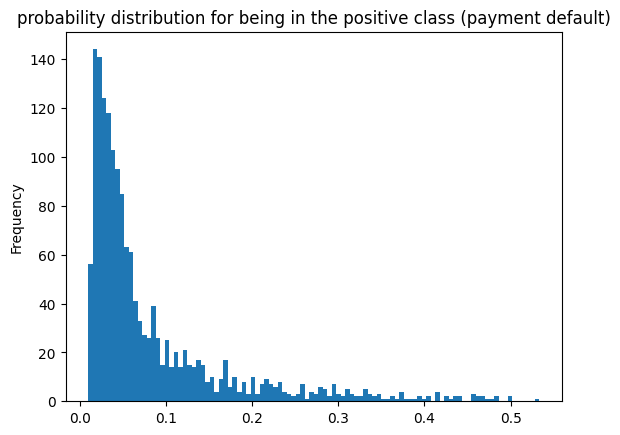

In [15]:
pd.Series(y_pred).plot(kind='hist', bins=100, title='probability distribution for being in the positive class (payment default)')
plt.show()


## 4.1.  [&#9650;](#toc0_) <a id='toc4_1_'></a>Local interpretability

In [5]:
# print the JS visualization code to the notebook
shap.initjs()


In [6]:
features_test = features.iloc[:10, :]
features_test

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,...,PAYMENT_MEAN_TO_ANNUITY_RATIO,CURRENT_TO_BUREAU_ANNUITY_MEAN_RATIO,CTA_CREDIT_TO_ANNUITY_MAX_RATIO,CTA_CREDIT_TO_ANNUITY_MEAN_RATIO,DAYS_DECISION_MEAN_TO_BIRTH,DAYS_CREDIT_MEAN_TO_BIRTH,DAYS_DECISION_MEAN_TO_EMPLOYED,DAYS_CREDIT_MEAN_TO_EMPLOYED,HOUR_APPR_RATIO,HOUR_APPR_DIFFERENCE
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
208439,0.0,1.0,0.0,0.0,270000.0,1375380.0,49531.5,1215000.0,0.0,0.0,...,0.212157,0.058314,0.720315,0.422831,0.062001,0.082651,0.219604,0.292725,0.967773,-0.398438
104411,0.0,1.0,0.0,0.0,157500.0,545040.0,26640.0,450000.0,0.0,0.0,...,0.786297,NaN,0.934659,0.581979,0.118045,0.065231,0.628418,0.347168,1.037109,0.468750
215453,0.0,0.0,1.0,0.0,135000.0,135000.0,14539.5,135000.0,0.0,0.0,...,1.080631,1.009183,0.609861,0.593940,0.034667,0.016344,0.088623,0.041779,1.407227,5.500000
295077,0.0,0.0,1.0,0.0,135000.0,166810.5,19926.0,144000.0,2.0,0.0,...,0.315590,0.542005,2.388060,1.774132,0.025760,0.038541,0.509766,0.762695,1.000000,0.000000
197357,1.0,1.0,1.0,0.0,135000.0,337500.0,16875.0,337500.0,0.0,0.0,...,0.630835,NaN,0.441891,0.441891,0.015758,0.075771,0.036133,0.173706,0.941406,-1.000000
299485,1.0,1.0,0.0,1.0,67500.0,135000.0,6750.0,135000.0,0.0,0.0,...,1.457067,NaN,1.000000,0.630508,0.079559,0.050849,0.496338,0.317139,0.937500,-0.664062
446551,0.0,1.0,0.0,0.0,81000.0,630000.0,18549.0,630000.0,0.0,1.0,...,0.890269,NaN,1.006800,0.606037,0.033883,0.059823,1.194336,2.107422,1.279297,2.398438
389819,0.0,1.0,0.0,0.0,135000.0,521280.0,23089.5,450000.0,3.0,0.0,...,0.346229,NaN,0.974606,0.850448,0.066463,0.044567,NaN,NaN,0.731934,-3.664062
179749,1.0,1.0,0.0,0.0,157500.0,450000.0,22500.0,450000.0,0.0,0.0,...,0.155762,NaN,1.103997,1.103995,0.023077,0.063248,0.197754,0.541992,0.928711,-1.000000


In [7]:
y_pred_test = model.predict_proba(features_test)
y_pred_test[:, 1]

array([0.02261432, 0.31116699, 0.06198099, 0.03867027, 0.04073736,
       0.16774121, 0.12950003, 0.21525545, 0.06337454, 0.24231094])

In [8]:
explainer = shap.TreeExplainer(model)
# shap values explainer with 3 fiels (values, base_values, data)
sv = explainer(features_test)

In [9]:
sv.values.shape

(10, 735, 2)

In [10]:
sv.base_values

array([[ 2.53672531, -2.53672531],
       [ 2.53672531, -2.53672531],
       [ 2.53672531, -2.53672531],
       [ 2.53672531, -2.53672531],
       [ 2.53672531, -2.53672531],
       [ 2.53672531, -2.53672531],
       [ 2.53672531, -2.53672531],
       [ 2.53672531, -2.53672531],
       [ 2.53672531, -2.53672531],
       [ 2.53672531, -2.53672531]])

Those values are on log odds scale : see [that post](https://github.com/shap/shap/issues/214)

In [11]:
# Get shap values explaining feature contribution to change the log odds
# for being in the risk customer class. 
exp = shap.Explanation(
    sv.values[:,:,1], 
    sv.base_values[:,1], 
    data=features.values, 
    feature_names=features.columns
)

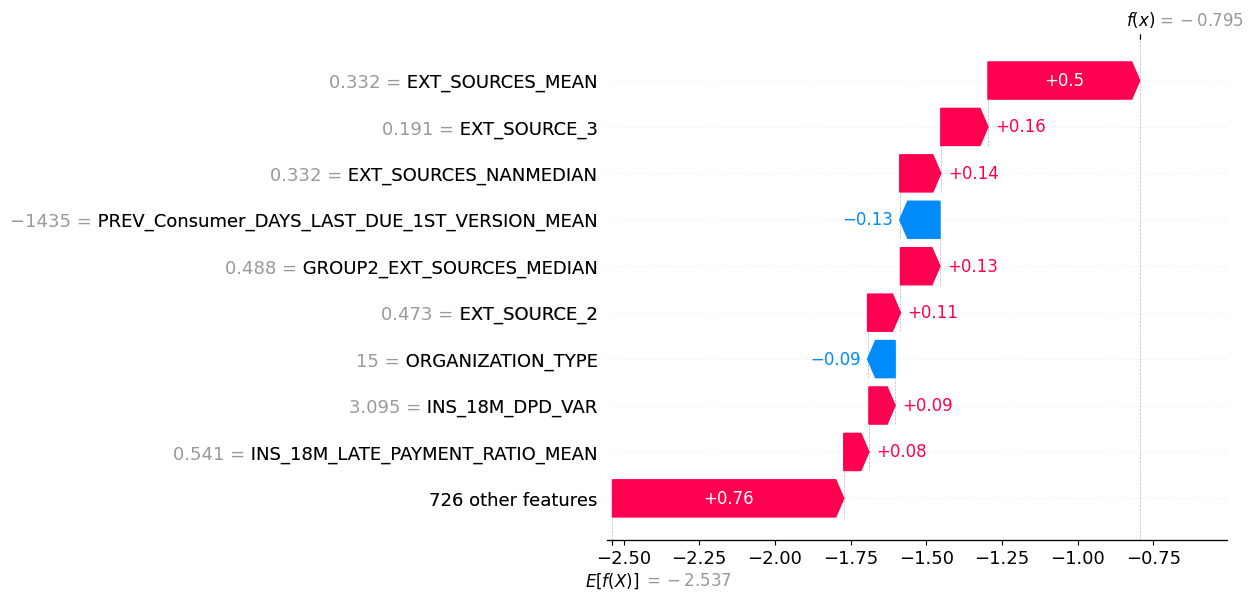

In [12]:
idx = 1
shap_plot = shap.plots.waterfall(exp[idx])

In [13]:
# check compatibility with predict proba
shap_values_idx= exp.values[idx, :]
shap_values_idx.shape


(735,)

In [14]:
import numpy as np

# Reconstructing the lgb output from shap_values:
def inv_logit(p): return np.exp(p) / (1 + np.exp(p))


In [15]:
base_value = exp.base_values[-1]
base_value

-2.5367253137924917

In [68]:
output = base_value + np.sum(shap_values_idx)  ## the remaining indexes are the the linear/additive contributions of each feature

print('Log-odds output:', output, ' Logistic output:', inv_logit(output))

Log-odds output: -0.7946691744301382  Logistic output: 0.31116698743806487


In [77]:
y_pred_test[idx][1]

0.31116698743806437

We found the probability predicted for the idx 1!

Let's do it once more for an individual with low probability prediction

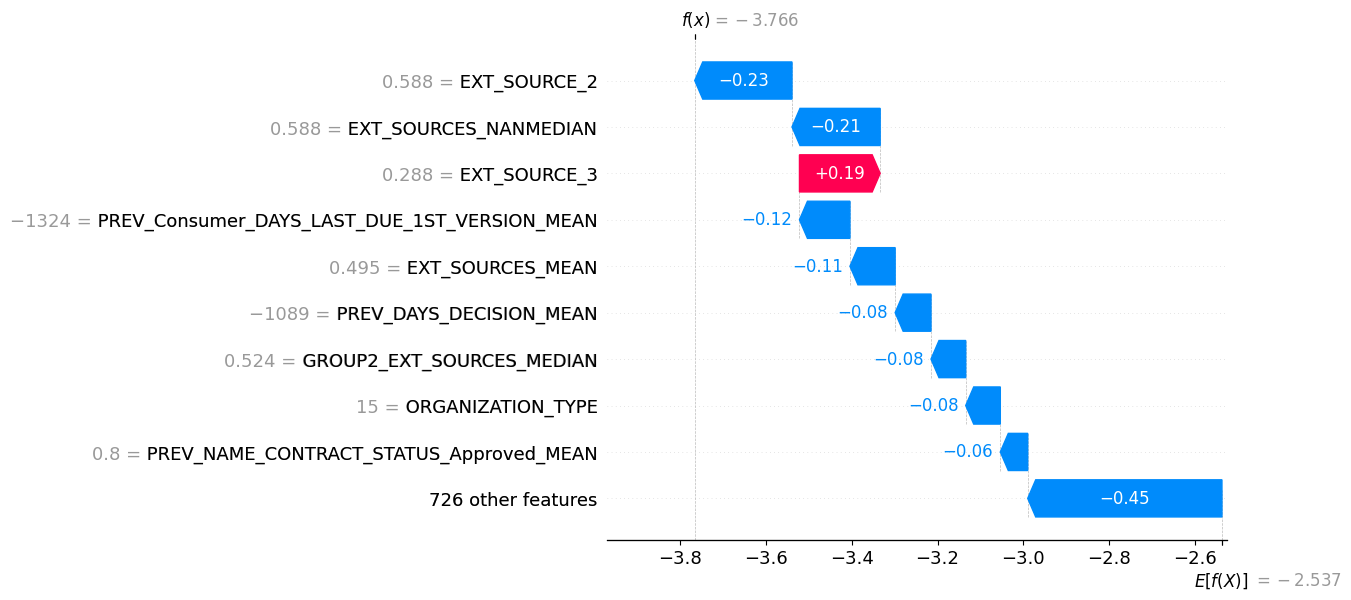

In [69]:
idx = 0
shap.plots.waterfall(exp[idx])

In [70]:
# check compatibility with predict proba
shap_values_idx= exp.values[idx, :]
shap_values_idx.shape

output = base_value + np.sum(shap_values_idx)  ## the remaining indexes are the the linear/additive contributions of each feature

print('Log-odds output:', output, ' Logistic output:', inv_logit(output))


Log-odds output: -3.7662978066347925  Logistic output: 0.02261432426673715


In [73]:
y_pred_test[idx][1]

0.022614324266737103

To summarize, in the log odds world, things work the same as in the probability world. 
When a feature pushes left, it makes the customer less risky, and vice versa.

## 4.2.  [&#9650;](#toc0_) <a id='toc4_2_'></a>Global interpretability

In [7]:
explainer = shap.TreeExplainer(model)
# shap values explainer with 3 fiels (values, base_values, data)
# On all individuals
sv = explainer(features)
exp = shap.Explanation(
    sv.values[:,:,1], 
    sv.base_values[:,1], 
    data=features.values, 
    feature_names=features.columns
)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
invalid value encountered in subtract


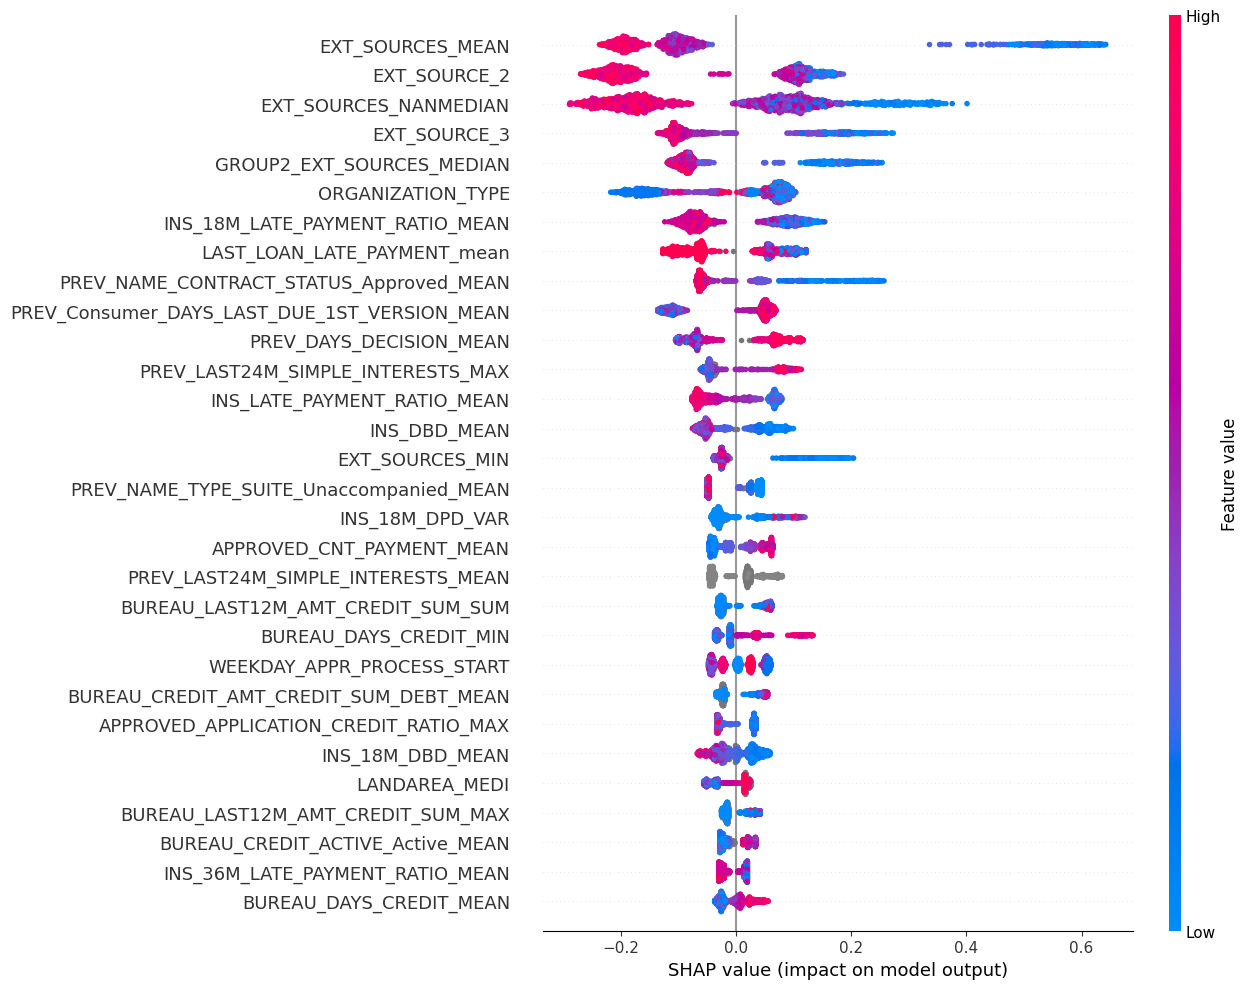

In [13]:
shap_plot = shap.summary_plot(
    exp,
    features,
    max_display=30,
    plot_size=(13,10),
)

In [10]:
def shap_html(plot):
    return f"<head>{shap.getjs()}</head><body>{plot.html()}</body>"

shap_html(shap_plot)

AttributeError: 'NoneType' object has no attribute 'html'

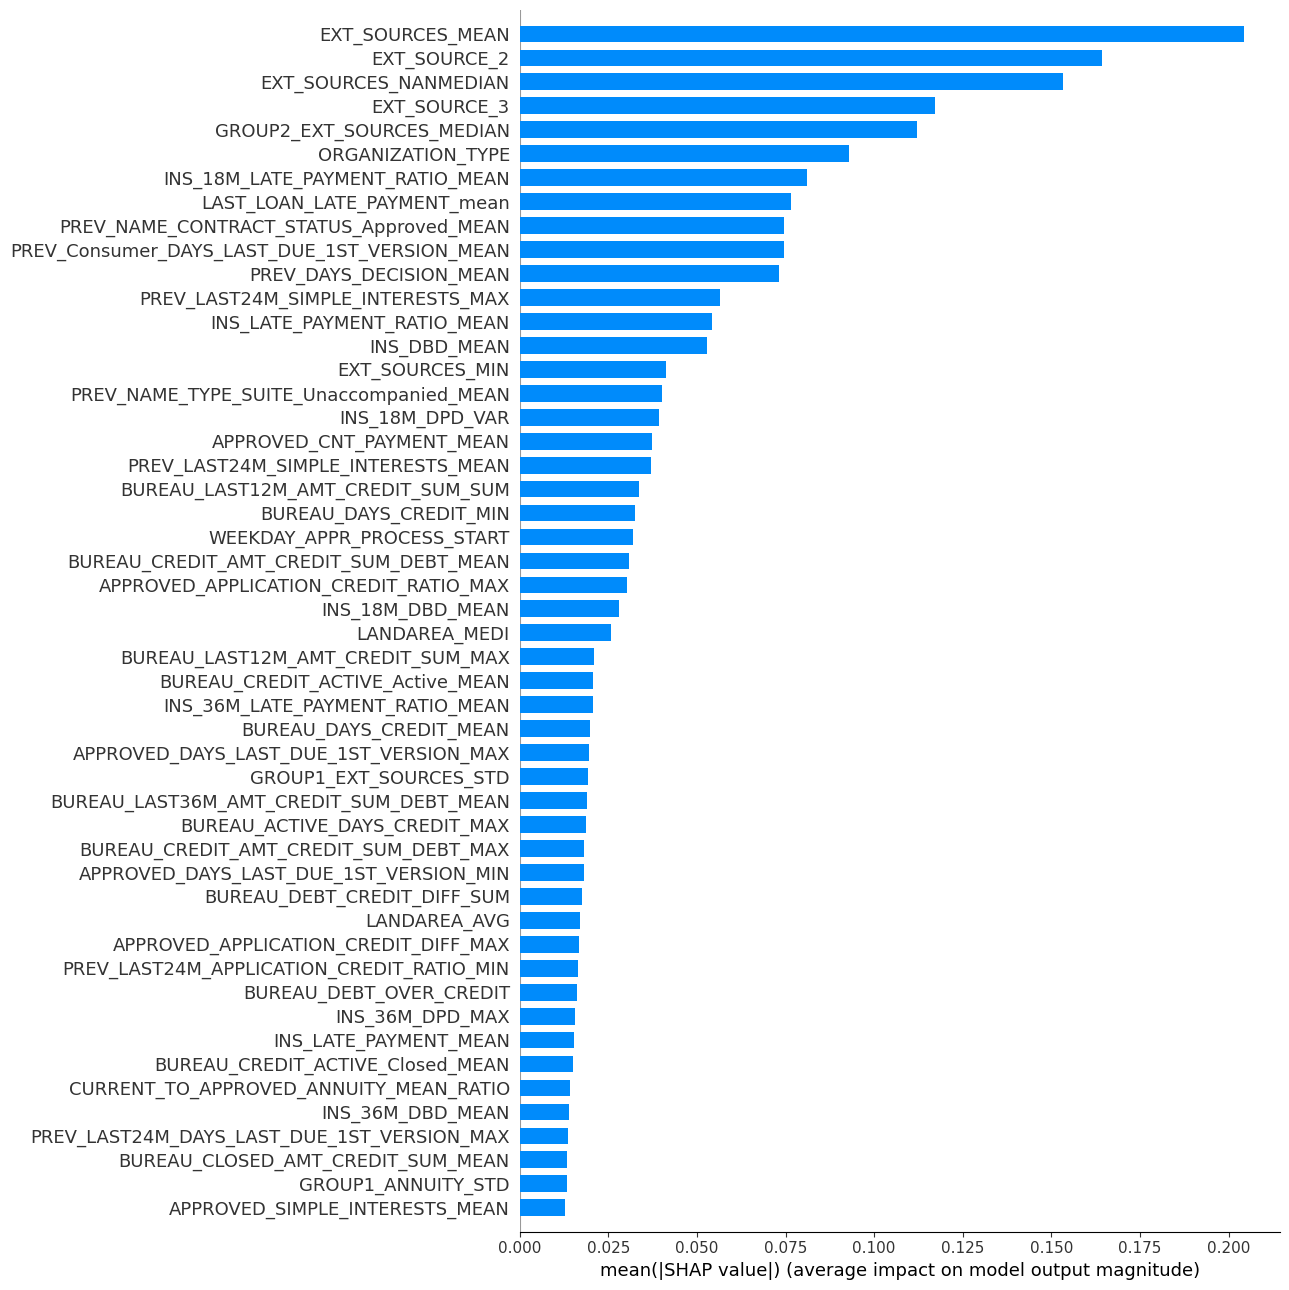

In [80]:
shap.summary_plot(
    exp,
    features,
    max_display=50,
    plot_size=(13,13),
    plot_type='bar',
)

## 4.3.  [&#9650;](#toc0_) <a id='toc4_3_'></a>How to automate the extraction of the feature importance rank.

In [81]:
shap_values_only1 = sv.values[:, :, 1]
shap_values_only0 = sv.values[:, :, 0]

In [86]:
shap_values_only0[0, :20]

array([0.        , 0.        , 0.        , 0.        , 0.0015606 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.0024047 ,
       0.        , 0.00226105, 0.        , 0.        , 0.00184678])

In [85]:
shap_values_only1[0, :20]

array([ 0.        ,  0.        ,  0.        ,  0.        , -0.0015606 ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.0024047 ,
        0.        , -0.00226105,  0.        ,  0.        , -0.00184678])

In [84]:
np.allclose(shap_values_only0, -shap_values_only1)

True

So the shap values for being in the two classes are opposite.

In [87]:
import numpy as np
vals= np.abs(shap_values_only1).mean(0)
vals.shape

(735,)

In [88]:
feature_importance = pd.DataFrame(list(zip(features.columns, vals)), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance.head(25)

,col_name,feature_importance_vals
88,EXT_SOURCES_MEAN,0.204293
32,EXT_SOURCE_2,0.164228
89,EXT_SOURCES_NANMEDIAN,0.153157
33,EXT_SOURCE_3,0.117072
112,GROUP2_EXT_SOURCES_MEDIAN,0.112048
30,ORGANIZATION_TYPE,0.092835
403,INS_18M_LATE_PAYMENT_RATIO_MEAN,0.081188
444,LAST_LOAN_LATE_PAYMENT_mean,0.076417
502,PREV_NAME_CONTRACT_STATUS_Approved_MEAN,0.074502
647,PREV_Consumer_DAYS_LAST_DUE_1ST_VERSION_MEAN,0.074427


## 4.4.  [&#9650;](#toc0_) <a id='toc4_4_'></a>Save shap plots

### 4.4.1.  [&#9650;](#toc0_) <a id='toc4_4_1_'></a>Summary_plot

In [8]:
explainer = shap.TreeExplainer(model)
# shap values explainer with 3 fiels (values, base_values, data)
# On all individuals
sv = explainer(features)
exp = shap.Explanation(
    sv.values[:,:,1], 
    sv.base_values[:,1], 
    data=features.values, 
    feature_names=features.columns
)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
invalid value encountered in subtract


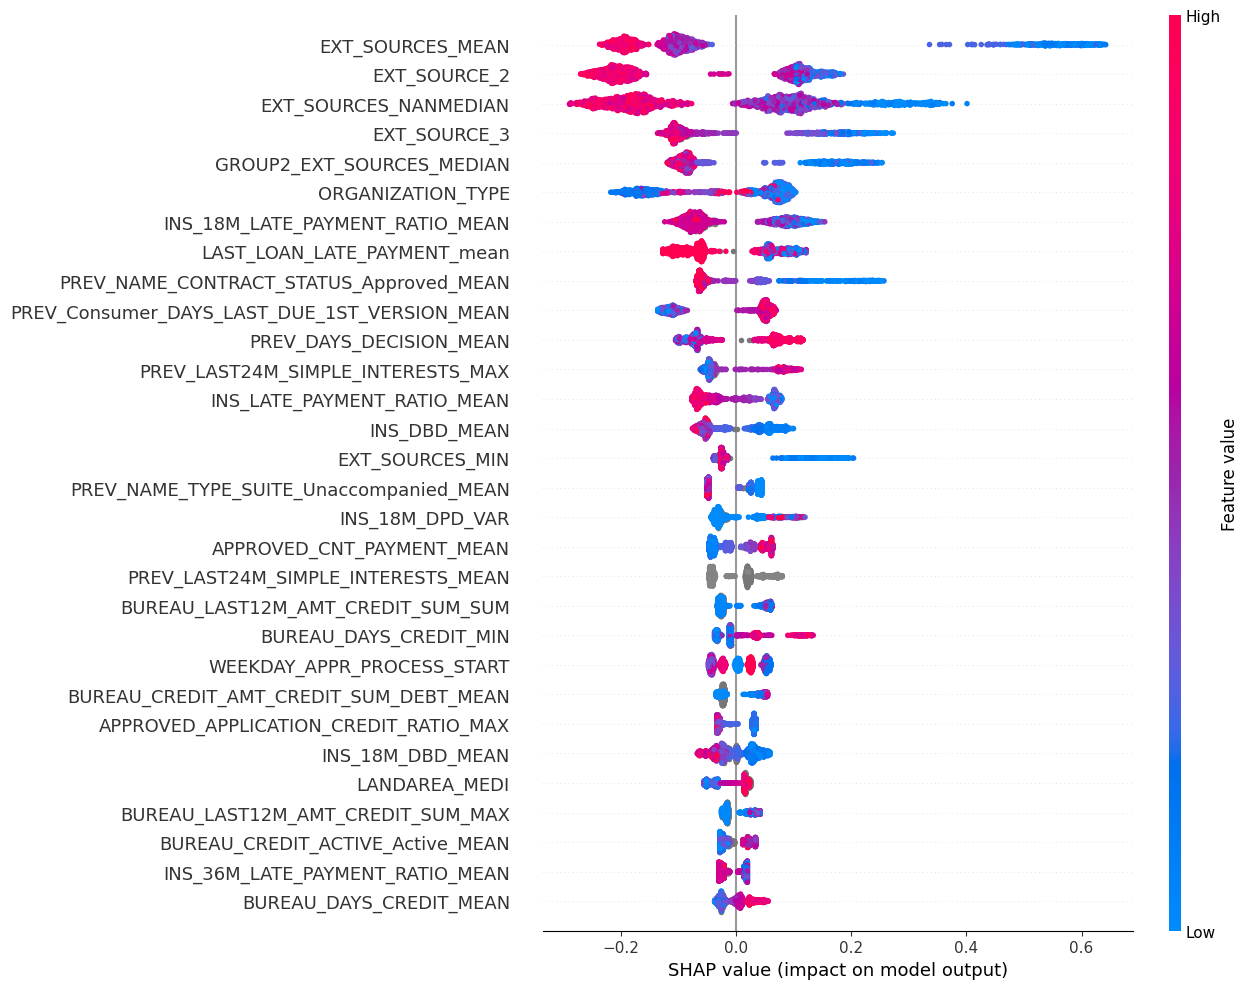

In [9]:
summary_plot = shap.summary_plot(
    exp,
    features,
    max_display=30,
    plot_size=(13,10),
)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
invalid value encountered in subtract


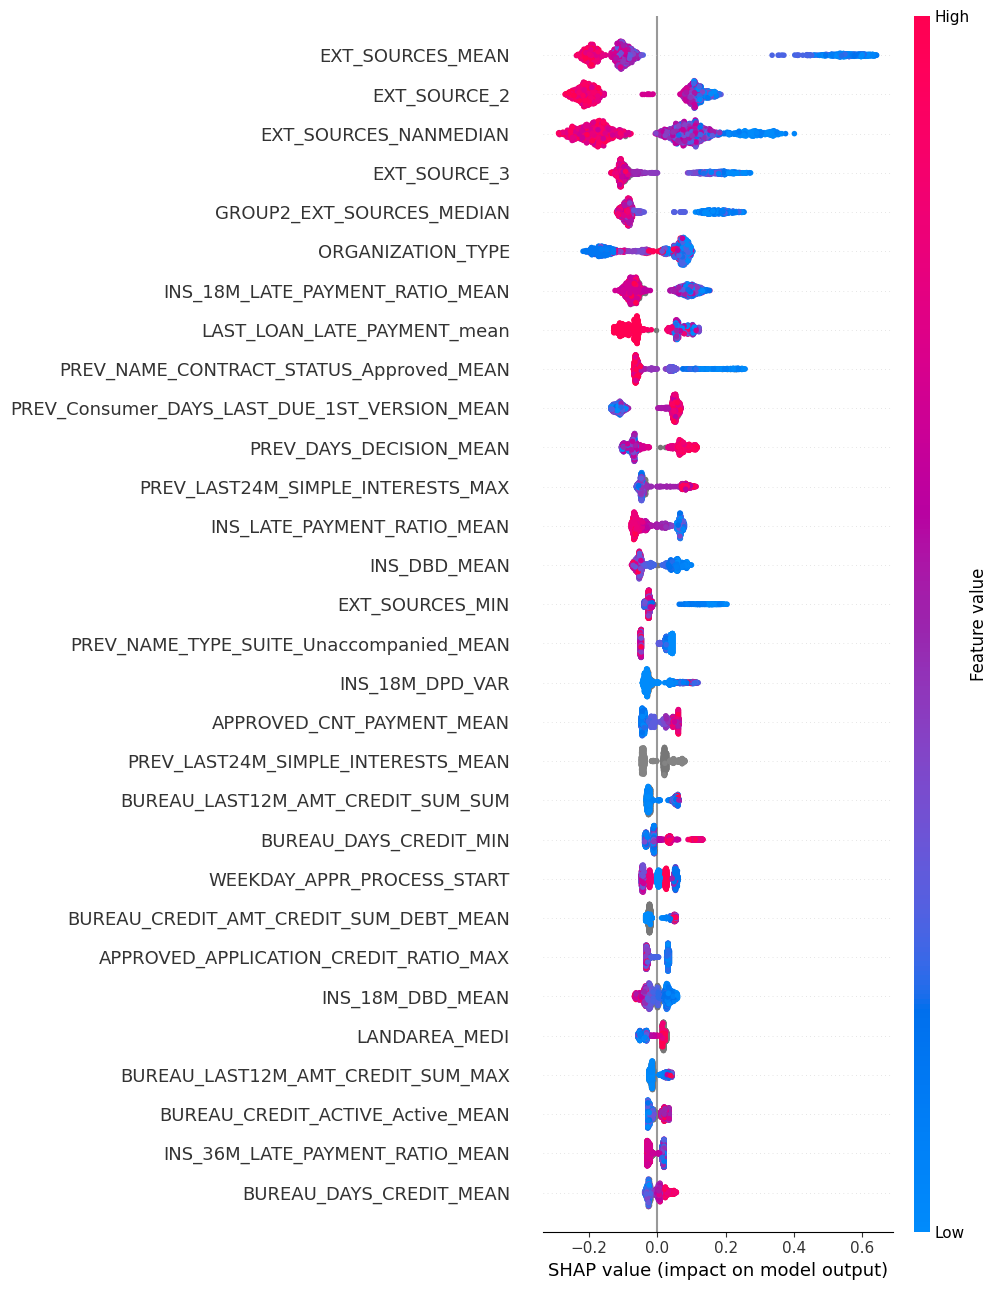

In [17]:
img_path = './shap_output/global_shap.png'
# Get the pyplot object without showing it
shap.summary_plot(
    exp,
    features,
    max_display=30,
    plot_size=(10,13),
    show=False
)
plt.savefig(img_path)
# shap.save_html('./shap_output/html/global_shap', summary_plot)

### 4.4.2.  [&#9650;](#toc0_) <a id='toc4_4_2_'></a>waterfall plot

In [37]:
img_path = './shap_output/local_shap2.png'
# Get the pyplot object without showing it
idx = 1
fig = plt.figure()
shap.plots.waterfall(exp[idx], show=False)
# Save the image locally
# plt.tight_layout()
fig.set_figwidth(5)
fig.set_figheight(4)

plt.savefig(img_path, bbox_inches='tight')

# shap.save_html('./shap_output/html/global_shap', summary_plot)

# Get_index from customer id and features dataframe

In [45]:
features.shape

(1600, 735)

In [46]:
features.reset_index().head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,PAYMENT_MEAN_TO_ANNUITY_RATIO,CURRENT_TO_BUREAU_ANNUITY_MEAN_RATIO,CTA_CREDIT_TO_ANNUITY_MAX_RATIO,CTA_CREDIT_TO_ANNUITY_MEAN_RATIO,DAYS_DECISION_MEAN_TO_BIRTH,DAYS_CREDIT_MEAN_TO_BIRTH,DAYS_DECISION_MEAN_TO_EMPLOYED,DAYS_CREDIT_MEAN_TO_EMPLOYED,HOUR_APPR_RATIO,HOUR_APPR_DIFFERENCE
0,208439,0.0,1.0,0.0,0.0,270000.0,1375380.0,49531.5,1215000.0,0.0,...,0.212157,0.058314,0.720315,0.422831,0.062001,0.082651,0.219604,0.292725,0.967773,-0.398438
1,104411,0.0,1.0,0.0,0.0,157500.0,545040.0,26640.0,450000.0,0.0,...,0.786297,NaN,0.934659,0.581979,0.118045,0.065231,0.628418,0.347168,1.037109,0.468750
2,215453,0.0,0.0,1.0,0.0,135000.0,135000.0,14539.5,135000.0,0.0,...,1.080631,1.009183,0.609861,0.593940,0.034667,0.016344,0.088623,0.041779,1.407227,5.500000
3,295077,0.0,0.0,1.0,0.0,135000.0,166810.5,19926.0,144000.0,2.0,...,0.315590,0.542005,2.388060,1.774132,0.025760,0.038541,0.509766,0.762695,1.000000,0.000000
4,197357,1.0,1.0,1.0,0.0,135000.0,337500.0,16875.0,337500.0,0.0,...,0.630835,NaN,0.441891,0.441891,0.015758,0.075771,0.036133,0.173706,0.941406,-1.000000


In [48]:
customer_id = 215453
features.reset_index().query('SK_ID_CURR == @customer_id')

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,PAYMENT_MEAN_TO_ANNUITY_RATIO,CURRENT_TO_BUREAU_ANNUITY_MEAN_RATIO,CTA_CREDIT_TO_ANNUITY_MAX_RATIO,CTA_CREDIT_TO_ANNUITY_MEAN_RATIO,DAYS_DECISION_MEAN_TO_BIRTH,DAYS_CREDIT_MEAN_TO_BIRTH,DAYS_DECISION_MEAN_TO_EMPLOYED,DAYS_CREDIT_MEAN_TO_EMPLOYED,HOUR_APPR_RATIO,HOUR_APPR_DIFFERENCE
2,215453,0.0,0.0,1.0,0.0,135000.0,135000.0,14539.5,135000.0,0.0,...,1.080631,1.009183,0.609861,0.59394,0.034667,0.016344,0.088623,0.041779,1.407227,5.5


In [53]:
def get_index(customer_id, features):
    return (
        features
        .reset_index()
        .query('SK_ID_CURR == @customer_id')
        .index
        .values[0]
    )

In [54]:
get_index(295077, features)

3

In [55]:
get_index(197357, features)

4

# Reflexion about caching local shap

In [56]:
import os 

customer_id = 100235
img_path = f'./shap_output/local_shap_{customer_id}.png'
if img_path in os.listdir('./shap_output/'):
    print('already requested and cached.')
    

In [58]:
os.listdir('./shap_output/')

['global_shap.png', 'local_shap.png', 'local_shap_100235.png']

In [60]:
os.path.split(img_path)

('./shap_output', 'local_shap_100235.png')

In [61]:
customer_id = 100235
img_path = f'./shap_output/local_shap_{customer_id}.png'
if os.path.split(img_path)[-1] in os.listdir('./shap_output/'):
    print('already requested and cached.')


already requested and cached.
